# Heart failure machine learning classication


### Import libraries

In [2]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
import time

# data visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
sns.set(style="whitegrid")

# useful data exploration libraries
from pandas_profiling import ProfileReport
import dabl

# machine learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# AutoML package
from flaml import AutoML
from flaml.ml import sklearn_metric_loss_score

c:\Users\vinhe\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


### Understand the data

In [3]:
# view first 5 rows
df = pd.read_csv('data/heart.csv')

In [3]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [4]:
df.shape

(918, 12)

In [5]:
# view data types of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
# summary of the numerical features and transpose to make it easier to read
df.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

In [7]:
# Get quick summary of categorical features
df.select_dtypes(include='object').describe().T

count unique     top freq
Sex              918      2       M  725
ChestPainType    918      4     ASY  496
RestingECG       918      3  Normal  552
ExerciseAngina   918      2       N  547
ST_Slope         918      3    Flat  460

In [8]:
# Look at categorical variables
for colname, coltype in df.dtypes.iteritems():
    if coltype == "object":
        print(colname)
        print(df[colname].unique())

Sex
['M' 'F']
ChestPainType
['ATA' 'NAP' 'ASY' 'TA']
RestingECG
['Normal' 'ST' 'LVH']
ExerciseAngina
['N' 'Y']
ST_Slope
['Up' 'Flat' 'Down']


In [9]:
# find out % of missing values for each column
missing_proportion = df.isnull().sum() / len(df) * 100
print(missing_proportion)

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64


### Understand the distribution of numerical columns and find potential outliers

Age


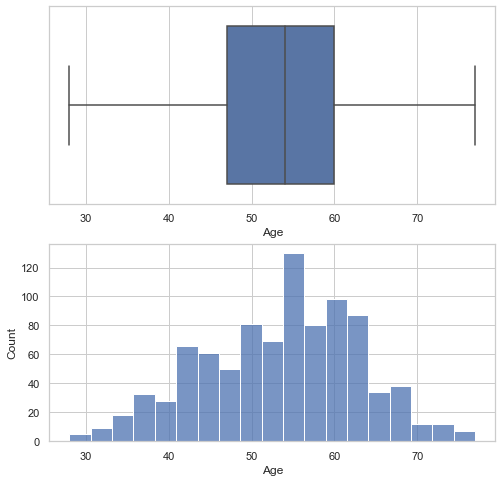

RestingBP


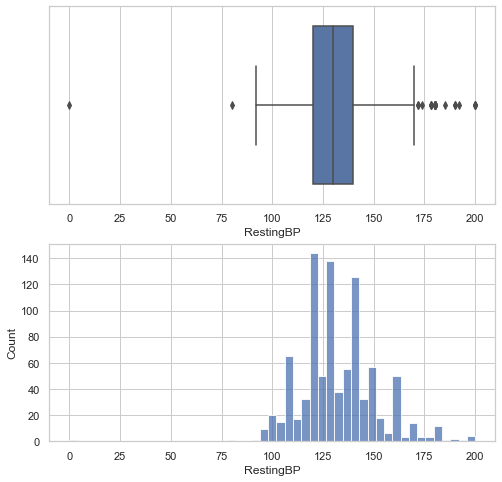

Cholesterol


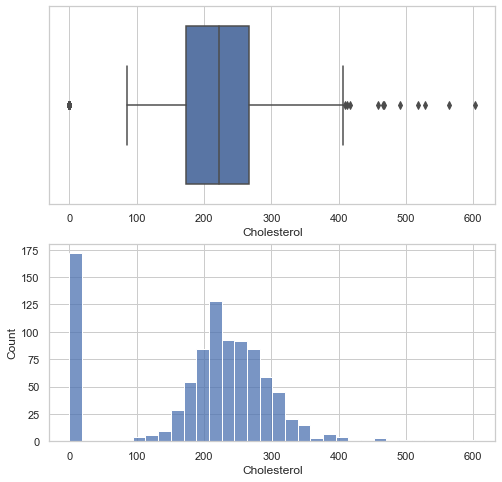

FastingBS


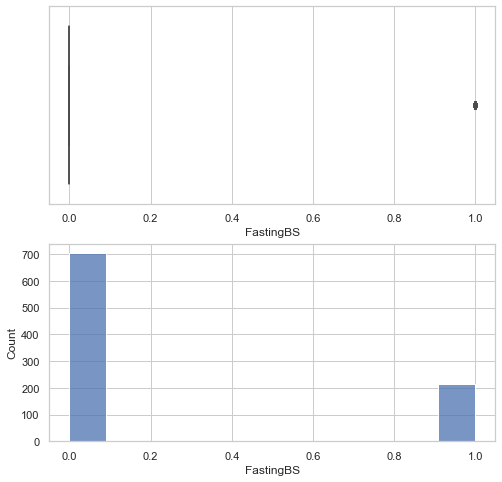

MaxHR


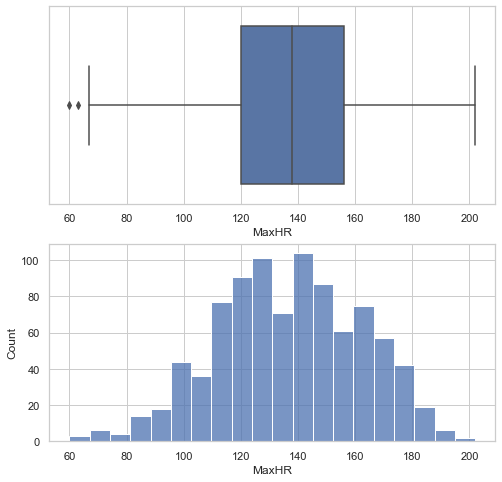

Oldpeak


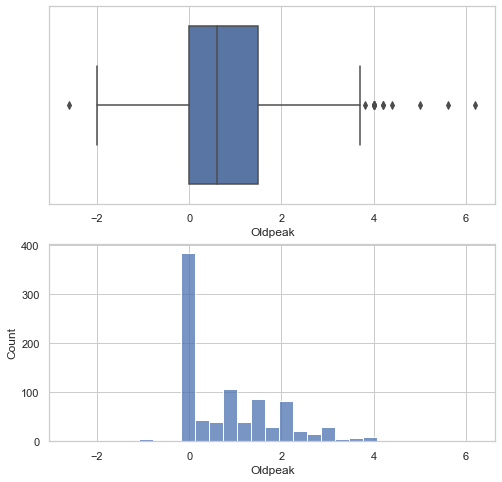

HeartDisease


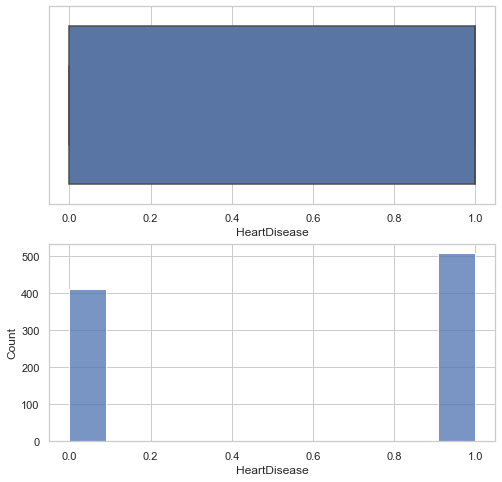

In [10]:
for colname, coltype in df.dtypes.iteritems():
    if (coltype == "float64") or (coltype == "int64"):
        print(colname)
        #fig, ax = plt.subplots(1, 2, figsize=(16,4))
        fig, ax = plt.subplots(2, 1, figsize=(8,8))
        sns.boxplot(data=df, x=colname, ax=ax[0])        
        sns.histplot(data=df, x=colname, ax=ax[1])
        plt.show()

In [11]:
# How unbalanced is the target feature?
heart_diseases  = df.groupby('HeartDisease').count().reset_index().iloc[:,1] / len(df)
print(heart_diseases)
print(f'Target feature skew: {stats.skew(df.HeartDisease)}')

0    0.446623
1    0.553377
Name: Age, dtype: float64
Target feature skew: -0.21473473034684154


In [12]:
# Find out how many records have 0 cholesterol and 0 RestingBP
print(f'There are {len(df[df.Cholesterol == 0])} records with 0 cholesterol. These will be converted to NaN values.')
print(f'There is {len(df[df.RestingBP == 0])} record with 0 RestingBP, this will be removed from the dataset')

df = df[df.RestingBP != 0]

There are 172 records with 0 cholesterol. These will be converted to NaN values.
There is 1 record with 0 RestingBP, this will be removed from the dataset


## Quick EDA

In [13]:
profile = ProfileReport(df)

In [14]:
profile

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\supervised.py:546: FutureWarning: The second positional argument of plot is a Series 'y'. If passing a column name, use a keyword.
  warnings.warn("The second positional argument of plot is a Series 'y'."


Target looks like classification
Linear Discriminant Analysis training set score: 0.752


c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


[[<Figure size 1080x1080 with 30 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 432x288 with 1 Axes>],
 None]

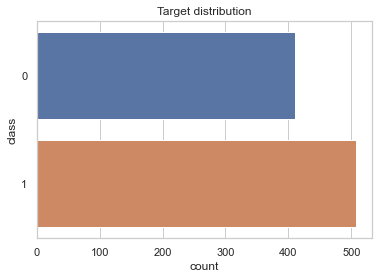

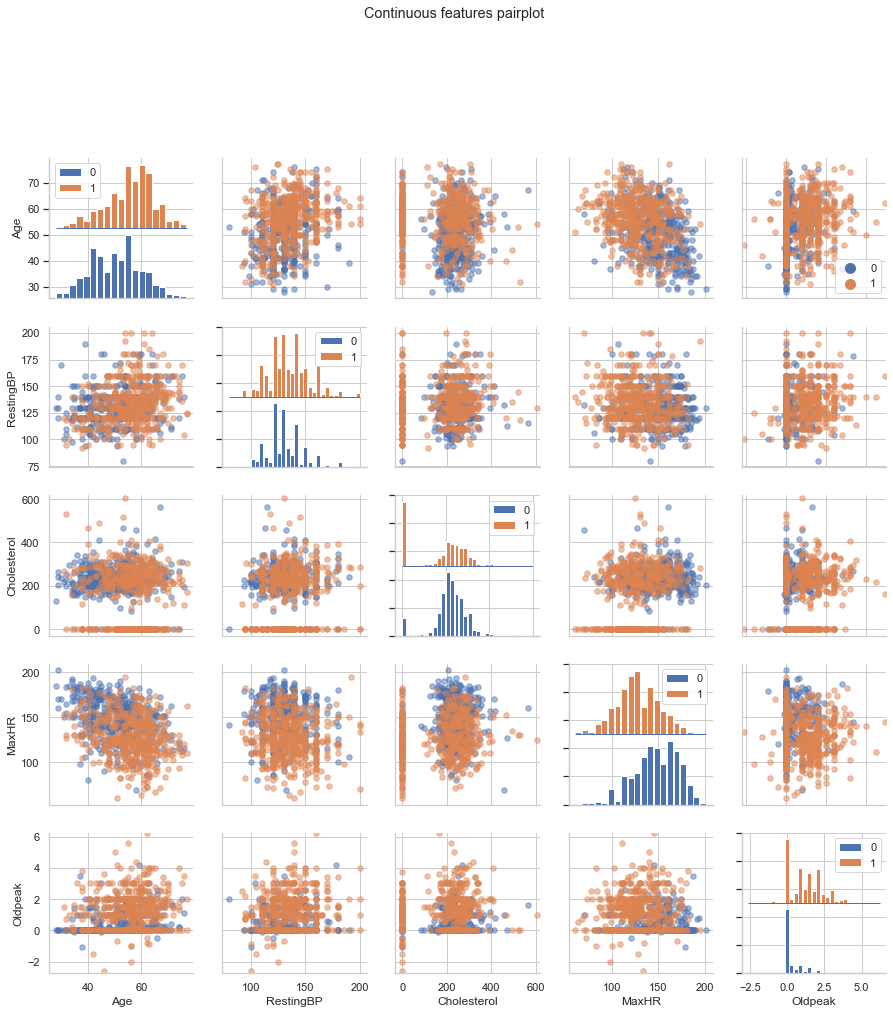

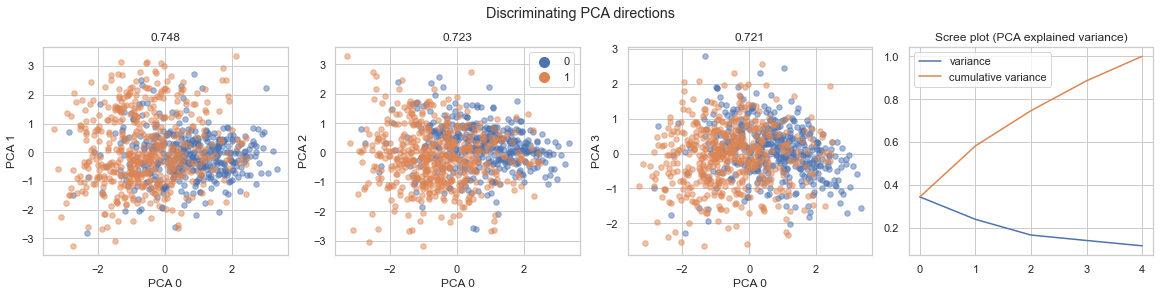

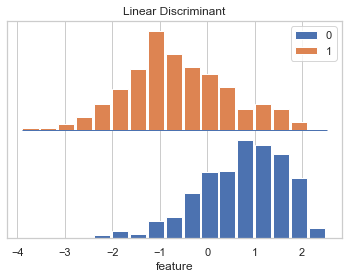

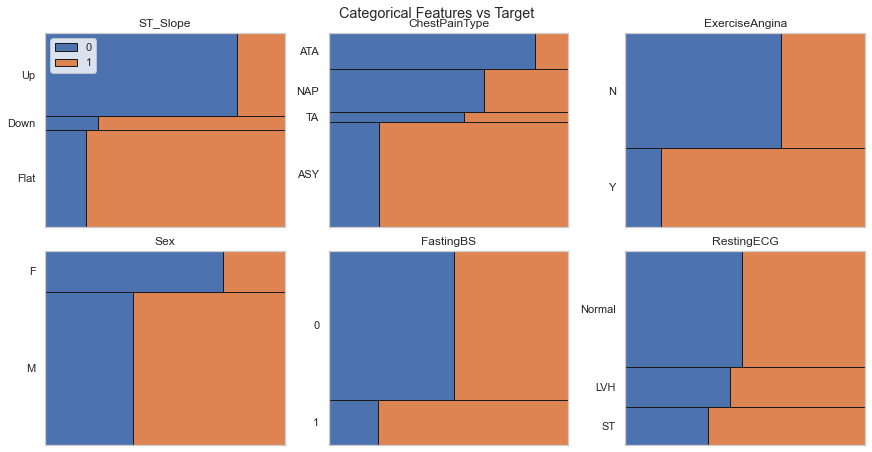

In [15]:
dabl.plot(df, "HeartDisease")

In [16]:
# Get more granular and split by target feature

def hist_and_boxplot(df, column, target):
    fig = px.histogram(df, x=column, color=target,
                       marginal="box")
    fig.update_layout(height=400, width=700, showlegend=True)
    fig.update_traces(marker_line_width=1,marker_line_color="black")
    fig.show()
    
for column in df.columns:
    hist_and_boxplot(df, column, "HeartDisease")

# Set baseline accuracy

In [17]:
# baseline accuracy, if we assumed every record was positive
base_line_accuracy = np.sum(df.HeartDisease)/df.shape[0]
base_line_accuracy

0.5528898582333697

# Model Building and Training 

### Process data to set benchmark machine learning

In [4]:
def get_dummies(df):
    '''
    Perform One Hot Encoding onto the dataset. 
    Columns were not dropped to improve model explainability. 
    '''
    _cat_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()
    _df_dummies = pd.get_dummies(df, columns=_cat_cols, drop_first=False)
    return _df_dummies

df_ohe = get_dummies(df)
df_ohe.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_F  Sex_M  ChestPainType_ASY  ...  ChestPainType_NAP  ChestPainType_TA  \
0      0      1                  0  ...                  0                 0   
1      1      0                  0  ...                  1                 0   
2      0      1                  0  ...                  0                 0   
3      1      0                  1  ...                  0                 0   
4      0      1                  0  ...                  1                 0   

   RestingECG_LVH  RestingECG_Normal  RestingECG_ST  ExerciseAngina_N  \
0               0                  1              0                 1   
1               0                  1              0                 1   
2               0                  0              1                 1   
3               0                  1              0                 0   
4               0                  1              0                 1   

   ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  ST_Slope_Up  
0                 0              0              0            1  
1                 0              0              1            0  
2                 0              0              0            1  
3                 1              0              1            0  
4                 0              0              0            1  

[5 rows x 21 columns]

In [5]:
def split_data(df, _test_size=0.2, _random_state=0):
    '''
    Split dataset into train, test, split
    '''
    X = df.iloc[:, df.columns != 'HeartDisease']
    y = df['HeartDisease']

    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=_test_size, 
                                                        random_state=_random_state,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df_ohe)

In [6]:
# Default logistic regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=5000)
# Default random forest
rf = RandomForestClassifier()
# Default XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric ='error')
# Default LightGBM
lgbm = LGBMClassifier()
# Default CatBoost
cat_boost = CatBoostClassifier(logging_level='Silent')

default_models = {
    "Logistic regression": log_reg, 
    "Random forest": rf,
    "XGBoost": xgb, 
    "LightGBM": lgbm, 
    "CatBoost": cat_boost
    }

In [7]:
def evaluate_models_once(X_train, X_test, y_train, y_test, models):
    '''
    Function to evaluate single instances of multiple machine learning models.
    '''
    for key, value in models.items():
        value.fit(X_train, y_train)
        _y_pred = value.predict(X_test)

        _confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, _y_pred),
            columns=["Predicted Survived", "Predicted Died"],
            index=["Survived", "Died"]) 

        _classification = classification_report(y_test, _y_pred)
        print(f"{key}------------------------------")
        print(f"Accuracy = {accuracy_score(y_test, _y_pred)}")
        print(f"Recall = {recall_score(y_test, _y_pred)}")
        print(f"Precision = {precision_score(y_test, _y_pred)}")
        print(f"F1 score = {f1_score(y_test, _y_pred)}")
        print(f"Classification report: \n {_classification}")
        print(f"Confusion matrix: \n {_confusion_matrix_df} \n")

In [21]:
# Evaluate default model performances, using a single run
evaluate_models_once(X_train, X_test, y_train, y_test, models=default_models)

Logistic regression------------------------------
Accuracy = 0.8586956521739131
Recall = 0.8431372549019608
Precision = 0.8958333333333334
F1 score = 0.8686868686868686
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        82
           1       0.90      0.84      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Confusion matrix: 
           Predicted Survived  Predicted Died
Survived                  72              10
Died                      16              86 

Random forest------------------------------
Accuracy = 0.8804347826086957
Recall = 0.8725490196078431
Precision = 0.9081632653061225
F1 score = 0.89
Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.89      0.87        82
           1       0.91      0.87      

In [8]:
def evaluate_models_multiple_times(df, models, number_of_runs):
    for key, value in models.items():
        start = time.time()
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for i in range(number_of_runs): 
            X_train, X_test, y_train, y_test = split_data(df, _random_state=i)
            value.fit(X_train, y_train)
            _y_pred = value.predict(X_test)
            accuracy_scores.append(accuracy_score(y_test, _y_pred))
            precision_scores.append(precision_score(y_test, _y_pred))
            recall_scores.append(recall_score(y_test, _y_pred))
            f1_scores.append(f1_score(y_test, _y_pred))
        
        print(f"For {number_of_runs} runs of a {key} model:")
        print(f"The mean accuracy was {round(np.mean(accuracy_scores), 3)} ")
        print(f"The mean precision was {round(np.mean(precision_scores), 3)} ")
        print(f"The mean recall was {round(np.mean(recall_scores),3)} ")
        print(f"The mean F1 score was {round(np.mean(f1_scores), 3)} ")
        print(f"This model took {round(time.time() - start, 1)}s to run {number_of_runs} times")
        print("---------------------------------------")

In [22]:
evaluate_models_multiple_times(
    df_ohe,
    models=default_models, 
    number_of_runs=10
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.864 
The mean precision was 0.866 
The mean recall was 0.893 
The mean F1 score was 0.879 
This model took 1.1s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.863 
The mean precision was 0.865 
The mean recall was 0.894 
The mean F1 score was 0.879 
This model took 1.6s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.852 
The mean precision was 0.86 
The mean recall was 0.877 
The mean F1 score was 0.868 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.858 
The mean precision was 0.866 
The mean recall was 0.881 
The mean F1 score was 0.873 
This model took 0.7s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.872 
The mean precision was 0

In [9]:
# Split dataset into feature variables and target feature for stratified K-folds evaluation
X = df_ohe.iloc[:, df_ohe.columns != 'HeartDisease']
y = df_ohe['HeartDisease']

In [24]:
def stratified_kfolds_model_eval(X, y, models, _n_splits=5, _n_repeats=10):
    '''
    Apply stratified K-folds to models and evaluate them.
    '''
    # log number of seconds to run function
    start = time.time() 

    # set cross validation
    _cv = RepeatedStratifiedKFold(n_splits=_n_splits, n_repeats=_n_repeats)
    
    # evaluate model
    scoring = ['accuracy', 'precision', 'recall', 'f1']

    for key, value in models.items():
        _start = time.time() 
        scores = cross_validate(estimator=value, X=X, y=y, scoring=scoring, cv=_cv, return_train_score=True)
        print(f"{key} -------------------------------------------")
        print(f"Accuracy: {round(scores.get('test_accuracy').mean(), 4)} (mean) & {round(scores.get('test_accuracy').std(), 4)} (std. dev.)")
        print(f"Precision: {round(scores.get('test_precision').mean(), 4)} (mean) & {round(scores.get('test_precision').std(), 4)} (std. dev.)")
        print(f"Recall: {round(scores.get('test_recall').mean(), 4)} (mean) & {round(scores.get('test_recall').std(), 4)} (std. dev.)")
        print(f"F1 score: {round(scores.get('test_f1').mean(), 4)} (mean) & {round(scores.get('test_f1').std(), 4)} (std. dev.)")
        print(f"This model took {round(time.time() - _start, 1)}s to run")
    end = time.time()
    print(f"This function took {round(end - start, 1)}s to run")

stratified_kfolds_model_eval(X, y, default_models, _n_repeats=10)

Logistic regression -------------------------------------------
Accuracy: 0.8621 (mean) & 0.0258 (std. dev.)
Precision: 0.8659 (mean) & 0.0314 (std. dev.)
Recall: 0.8895 (mean) & 0.0329 (std. dev.)
F1 score: 0.877 (mean) & 0.0229 (std. dev.)
This model took 6.9s to run
Random forest -------------------------------------------
Accuracy: 0.8674 (mean) & 0.0207 (std. dev.)
Precision: 0.8651 (mean) & 0.0222 (std. dev.)
Recall: 0.9014 (mean) & 0.0304 (std. dev.)
F1 score: 0.8825 (mean) & 0.0188 (std. dev.)
This model took 8.6s to run
XGBoost -------------------------------------------
Accuracy: 0.8595 (mean) & 0.021 (std. dev.)
Precision: 0.8631 (mean) & 0.0275 (std. dev.)
Recall: 0.8884 (mean) & 0.0362 (std. dev.)
F1 score: 0.8748 (mean) & 0.0192 (std. dev.)
This model took 4.8s to run
LightGBM -------------------------------------------
Accuracy: 0.8627 (mean) & 0.0187 (std. dev.)
Precision: 0.8657 (mean) & 0.0274 (std. dev.)
Recall: 0.8911 (mean) & 0.0229 (std. dev.)
F1 score: 0.8778 (me

In [25]:
def get_logistic_regression_feature_importance(X_train, y_train, model):
    model.fit(X_train, y_train)
    #print(value.coef_)

    _coef = list(model.coef_.flatten())
    feature_importance = pd.DataFrame(
        {"Feature": X_train.columns,
        "Importance": _coef}
        )
    return feature_importance.sort_values(by="Importance", ascending=False)

get_logistic_regression_feature_importance(X_train, y_train, model=log_reg)

Feature  Importance
8   ChestPainType_ASY    1.094824
18      ST_Slope_Flat    1.040641
3           FastingBS    0.954045
7               Sex_M    0.548189
16   ExerciseAngina_Y    0.397143
5             Oldpeak    0.257690
12     RestingECG_LVH    0.212911
0                 Age    0.014475
1           RestingBP    0.009348
2         Cholesterol   -0.004162
4               MaxHR   -0.010432
13  RestingECG_Normal   -0.141751
17      ST_Slope_Down   -0.204806
11   ChestPainType_TA   -0.205303
14      RestingECG_ST   -0.293035
10  ChestPainType_NAP   -0.379617
15   ExerciseAngina_N   -0.619018
9   ChestPainType_ATA   -0.731778
6               Sex_F   -0.770064
19        ST_Slope_Up   -1.057710

In [53]:
tree_models = {
    "Random forest": rf,
    "XGBoost": xgb, 
    "LightGBM": lgbm, 
    "CatBoost": cat_boost
    }

def get_tree_model_feature_importance(X_train, y_train, models):
    for key, value in models.items():
        value.fit(X_train, y_train)
        #print(value.coef_)

        #_coef = list(value.coef_.flatten())
        feature_importance = pd.DataFrame(
            {f"{key} Feature": X_train.columns,
            "Importance": value.feature_importances_}
            )
        
        print(f"{key} ------------------------------")
        print(feature_importance.sort_values(by="Importance", ascending=False))

In [26]:
get_tree_model_feature_importance(X_train, y_train, tree_models)

Random forest ------------------------------
   Random forest Feature  Importance
19           ST_Slope_Up    0.125360
18         ST_Slope_Flat    0.101952
4                  MaxHR    0.099003
2            Cholesterol    0.092828
5                Oldpeak    0.088246
8      ChestPainType_ASY    0.077085
0                    Age    0.072329
1              RestingBP    0.067426
16      ExerciseAngina_Y    0.063777
15      ExerciseAngina_N    0.048782
3              FastingBS    0.025275
6                  Sex_F    0.025231
7                  Sex_M    0.024059
9      ChestPainType_ATA    0.023561
12        RestingECG_LVH    0.015618
10     ChestPainType_NAP    0.013596
13     RestingECG_Normal    0.012933
14         RestingECG_ST    0.009180
17         ST_Slope_Down    0.007644
11      ChestPainType_TA    0.006115
XGBoost ------------------------------
      XGBoost Feature  Importance
19        ST_Slope_Up    0.782083
8   ChestPainType_ASY    0.046852
15   ExerciseAngina_N    0.021930
6  

# Now let's rebalance the target feature
Make sure to split data first and then apply sampling methods.
## Try undersampling

In [27]:
def undersample_data(X_train, y_train, random_state=0):
    '''
    Function to apply random undersampling after the dataset has been split into 
    training and test data, to prevent data leakage. Undersampling is a 
    technique to balance the target feature.
    '''
    random_state = random_state
    train_data = pd.concat([X_train, y_train], axis=1)

    # Class count
    count_class_1, count_class_0 = train_data.HeartDisease.value_counts()

    # Divide by class
    df_class_0 = train_data[train_data['HeartDisease'] == 0]
    df_class_1 = train_data[train_data['HeartDisease'] == 1]

    # Undersample 0-class and concat the DataFrames of both class
    df_class_1_under = df_class_1.sample(count_class_0)
    df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)

    X_train_under = df_test_under.drop('HeartDisease', axis='columns')
    y_train_under = df_test_under['HeartDisease']
    
    return X_train_under, y_train_under


In [28]:
X_train_under, y_train_under = undersample_data(X_train, y_train)

In [29]:
def evaluate_resampled_models_multiple_times(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    models, 
    number_of_runs,
    sampling_type
    ):
    for key, value in models.items():
        start = time.time()
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for _ in range(number_of_runs):
            if sampling_type == 'undersampling':
                X_train, y_train = undersample_data(X_train, y_train, random_state=_)
            elif sampling_type == 'oversampling':
                X_train, y_train = oversample_data(X_train, y_train, random_state=_)
            else:
                X_train, y_train = smote_data(X_train, y_train, random_state=_)

            value.fit(X_train, y_train)
            _y_pred = value.predict(X_test)
            accuracy_scores.append(accuracy_score(y_test, _y_pred))
            precision_scores.append(precision_score(y_test, _y_pred))
            recall_scores.append(recall_score(y_test, _y_pred))
            f1_scores.append(f1_score(y_test, _y_pred))
        
        print(f"For {number_of_runs} runs of a {key} model:")
        print(f"The mean accuracy was {round(np.mean(accuracy_scores), 3)} ")
        print(f"The mean precision was {round(np.mean(precision_scores), 3)} ")
        print(f"The mean recall was {round(np.mean(recall_scores),3)} ")
        print(f"The mean F1 score was {round(np.mean(f1_scores), 3)} ")
        print(f"This model took {round(time.time() - start, 1)}s to run {number_of_runs} times")
        print("---------------------------------------")

In [30]:
# See which default model performs best with random undersampling
evaluate_resampled_models_multiple_times(
    X_train_under, 
    X_test, 
    y_train_under, 
    y_test, 
    models=default_models, 
    number_of_runs=10,
    sampling_type='undersampling'
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.848 
The mean precision was 0.905 
The mean recall was 0.812 
The mean F1 score was 0.856 
This model took 1.5s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.867 
The mean precision was 0.923 
The mean recall was 0.83 
The mean F1 score was 0.874 
This model took 1.5s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.832 
The mean precision was 0.899 
The mean recall was 0.784 
The mean F1 score was 0.838 
This model took 0.8s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.821 
The mean precision was 0.879 
The mean recall was 0.784 
The mean F1 score was 0.829 
This model took 0.7s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.887 
The mean precision was 0

### Now try oversampling

In [31]:
def oversample_data(X_train, y_train, random_state=0):
    '''
    Function to apply random oversampling after the dataset has been split into 
    training and test data, to prevent data leakage. Undersampling is a 
    technique to balance the target feature.
    '''
    random_state = random_state
    train_data = pd.concat([X_train, y_train], axis=1)

    # Class count
    count_class_1, count_class_0 = train_data.HeartDisease.value_counts()

    # Divide by class
    df_class_0 = train_data[train_data['HeartDisease'] == 0]
    df_class_1 = train_data[train_data['HeartDisease'] == 1]

    # Oversample 1-class and concat the DataFrames of both classes
    df_class_0_over = df_class_0.sample(count_class_1, replace=True)
    df_test_over = pd.concat([df_class_1, df_class_0_over], axis=0)

    X_train_over = df_test_over.drop('HeartDisease', axis='columns')
    y_train_over = df_test_over['HeartDisease']
    
    return X_train_over, y_train_over   

In [32]:
X_train_over, y_train_over = oversample_data(X_train, y_train)

In [33]:
# See which default model performs best with random oversampling
evaluate_resampled_models_multiple_times(
    X_train_over, 
    X_test, 
    y_train_over, 
    y_test, 
    models=default_models, 
    number_of_runs=10,
    sampling_type = 'oversampling'
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.847 
The mean precision was 0.897 
The mean recall was 0.818 
The mean F1 score was 0.855 
This model took 2.3s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.818 
The mean precision was 0.765 
The mean recall was 0.971 
The mean F1 score was 0.856 
This model took 1.5s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.801 
The mean precision was 0.748 
The mean recall was 0.965 
The mean F1 score was 0.843 
This model took 0.7s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.73 
The mean precision was 0.678 
The mean recall was 0.98 
The mean F1 score was 0.801 
This model took 0.7s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.73 
The mean precision was 0.6

## Try SMOTE

In [34]:
def smote_data(X_train, y_train, random_state=0):
    smote = SMOTE(sampling_strategy='minority', random_state=random_state)

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    return X_train_smote, y_train_smote

In [35]:
X_train_smote, y_train_smote = smote_data(X_train, y_train)

In [36]:
# See which default model performs best with SMOTE oversampling
evaluate_resampled_models_multiple_times(
    X_train_smote, 
    X_test, 
    y_train_smote, 
    y_test, 
    models=default_models, 
    number_of_runs=10,
    sampling_type = 'smote'
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.859 
The mean precision was 0.904 
The mean recall was 0.833 
The mean F1 score was 0.867 
This model took 2.3s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.876 
The mean precision was 0.915 
The mean recall was 0.856 
The mean F1 score was 0.884 
This model took 1.6s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.815 
The mean precision was 0.878 
The mean recall was 0.775 
The mean F1 score was 0.823 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.832 
The mean precision was 0.874 
The mean recall was 0.814 
The mean F1 score was 0.843 
This model took 0.8s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.875 
The mean precision was 

# Feature engineering: bin numerical features

In [37]:
def bin_numerical_features(split_df):
    numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
    for col in numerical_cols:
        split_df[f'{col}_binned'] = pd.qcut(
            split_df[col], 
            4, 
            labels=['1', '2', '3', '4'],
            duplicates = 'drop'
            )
    split_df.drop(columns=numerical_cols, inplace=True)
    for col in numerical_cols:
        split_df[f'{col}_binned'] = split_df[f'{col}_binned'].astype(str)
        split_df[f'{col}_binned'] = split_df[f'{col}_binned'].str.replace(',', '-', regex=True)
    for col in numerical_cols:   
        split_df[f'{col}_binned'] = split_df[f'{col}_binned'].str.replace(']', '', regex=True)
    split_df_binned_ohe = get_dummies(split_df)    
    
    return split_df_binned_ohe

In [38]:
def evaluate_binned_models_multiple_times(df, models, number_of_runs):
    for key, value in models.items():
        start = time.time()
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for i in range(number_of_runs): 
            X_train, X_test, y_train, y_test = split_data(df, _random_state=i)
            X_train = bin_numerical_features(X_train)
            X_test = bin_numerical_features(X_test)
            value.fit(X_train, y_train)
            _y_pred = value.predict(X_test)
            accuracy_scores.append(accuracy_score(y_test, _y_pred))
            precision_scores.append(precision_score(y_test, _y_pred))
            recall_scores.append(recall_score(y_test, _y_pred))
            f1_scores.append(f1_score(y_test, _y_pred))
        
        print(f"For {number_of_runs} runs of a {key} model:")
        print(f"The mean accuracy was {round(np.mean(accuracy_scores), 3)} ")
        print(f"The mean precision was {round(np.mean(precision_scores), 3)} ")
        print(f"The mean recall was {round(np.mean(recall_scores),3)} ")
        print(f"The mean F1 score was {round(np.mean(f1_scores), 3)} ")
        print(f"This model took {round(time.time() - start, 1)}s to run {number_of_runs} times")
        print("---------------------------------------")

In [39]:
evaluate_binned_models_multiple_times(
    df = df_ohe,
    models=default_models, 
    number_of_runs=10    
)

For 10 runs of a Logistic regression model:
The mean accuracy was 0.861 
The mean precision was 0.862 
The mean recall was 0.893 
The mean F1 score was 0.877 
This model took 0.4s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.854 
The mean precision was 0.854 
The mean recall was 0.891 
The mean F1 score was 0.872 
This model took 1.9s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.855 
The mean precision was 0.865 
The mean recall was 0.877 
The mean F1 score was 0.871 
This model took 1.3s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.864 
The mean precision was 0.873 
The mean recall was 0.883 
The mean F1 score was 0.878 
This model took 1.1s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.874 
The mean precision was 

# Feature engineering: scale the data

In [40]:
numerical_cols_oldpeak = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
max_abs_scaler = MaxAbsScaler()

## Test standard scaling

In [41]:
def scale_split_df(split_df, scaler):
    split_df[numerical_cols_oldpeak] = scaler.fit_transform(split_df[numerical_cols_oldpeak])
    return split_df

def evaluate_scaled_models_multiple_times(df, models, number_of_runs, scaler):
    for key, value in models.items():
        start = time.time()
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for i in range(number_of_runs): 
            X_train, X_test, y_train, y_test = split_data(df, _random_state=i)
            X_train = scale_split_df(X_train, scaler)
            X_test = scale_split_df(X_test, scaler)
            value.fit(X_train, y_train)
            _y_pred = value.predict(X_test)
            accuracy_scores.append(accuracy_score(y_test, _y_pred))
            precision_scores.append(precision_score(y_test, _y_pred))
            recall_scores.append(recall_score(y_test, _y_pred))
            f1_scores.append(f1_score(y_test, _y_pred))
        
        print(f"For {number_of_runs} runs of a {key} model:")
        print(f"The mean accuracy was {round(np.mean(accuracy_scores), 3)} ")
        print(f"The mean precision was {round(np.mean(precision_scores), 3)} ")
        print(f"The mean recall was {round(np.mean(recall_scores),3)} ")
        print(f"The mean F1 score was {round(np.mean(f1_scores), 3)} ")
        print(f"This model took {round(time.time() - start, 1)}s to run {number_of_runs} times")
        print("---------------------------------------")

In [42]:
evaluate_scaled_models_multiple_times(
    df = df_ohe, 
    models = default_models, 
    number_of_runs = 10, 
    scaler = standard_scaler
)

For 10 runs of a Logistic regression model:
The mean accuracy was 0.864 
The mean precision was 0.866 
The mean recall was 0.892 
The mean F1 score was 0.879 
This model took 0.2s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.859 
The mean precision was 0.862 
The mean recall was 0.89 
The mean F1 score was 0.875 
This model took 1.6s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.853 
The mean precision was 0.862 
The mean recall was 0.876 
The mean F1 score was 0.868 
This model took 1.0s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.856 
The mean precision was 0.864 
The mean recall was 0.88 
The mean F1 score was 0.871 
This model took 0.8s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.871 
The mean precision was 0.

### Test min-max scaler

In [43]:
evaluate_scaled_models_multiple_times(
    df = df_ohe, 
    models = default_models, 
    number_of_runs = 10, 
    scaler = min_max_scaler
)

For 10 runs of a Logistic regression model:
The mean accuracy was 0.855 
The mean precision was 0.864 
The mean recall was 0.876 
The mean F1 score was 0.87 
This model took 0.3s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.857 
The mean precision was 0.857 
The mean recall was 0.891 
The mean F1 score was 0.874 
This model took 1.6s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.828 
The mean precision was 0.828 
The mean recall was 0.872 
The mean F1 score was 0.848 
This model took 1.0s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.835 
The mean precision was 0.831 
The mean recall was 0.882 
The mean F1 score was 0.855 
This model took 0.8s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.859 
The mean precision was 0

### Test absolute maximum scaler

In [44]:
evaluate_scaled_models_multiple_times(
    df = df_ohe, 
    models = default_models, 
    number_of_runs = 10, 
    scaler = max_abs_scaler
)

For 10 runs of a Logistic regression model:
The mean accuracy was 0.859 
The mean precision was 0.866 
The mean recall was 0.883 
The mean F1 score was 0.874 
This model took 0.2s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.864 
The mean precision was 0.863 
The mean recall was 0.899 
The mean F1 score was 0.88 
This model took 1.7s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.845 
The mean precision was 0.844 
The mean recall was 0.885 
The mean F1 score was 0.864 
This model took 1.0s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.848 
The mean precision was 0.84 
The mean recall was 0.897 
The mean F1 score was 0.867 
This model took 0.8s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.862 
The mean precision was 0.

# FLAML to automate hyperparameter tuning

In [45]:
automl = AutoML()

settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'f1',
    "task": 'classification',
    "verbose": 3,
    "estimator_list": ["rf", "xgboost", "lgbm", "catboost"],
    "log_file_name": 'heart_failure_logger.log',  # flaml log file
    "eval_method": "cv",
    "n_splits": 5,
    "seed": 1,    # random seed
}

In [46]:
automl.fit(X_train, y_train, **settings)

[flaml.automl: 08-04 21:01:05] {2427} INFO - task = classification
[flaml.automl: 08-04 21:01:05] {2429} INFO - Data split method: stratified
[flaml.automl: 08-04 21:01:05] {2432} INFO - Evaluation method: cv
[flaml.automl: 08-04 21:01:05] {2551} INFO - Minimizing error metric: 1-f1
[flaml.automl: 08-04 21:01:05] {2691} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost', 'lgbm', 'catboost']
[flaml.automl: 08-04 21:01:05] {2993} INFO - iteration 0, current learner rf
[flaml.automl: 08-04 21:01:05] {3126} INFO - Estimated sufficient time budget=1204s. Estimated necessary time budget=1s.
[flaml.automl: 08-04 21:01:05] {3173} INFO -  at 0.2s,	estimator rf's best error=0.1573,	best estimator rf's best error=0.1573
[flaml.automl: 08-04 21:01:05] {2993} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-04 21:01:05] {3173} INFO -  at 0.2s,	estimator lgbm's best error=0.1527,	best estimator lgbm's best error=0.1527
[flaml.automl: 08-04 21:01:05] {2993} INFO - iteration 2, curre

In [47]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparameter:', automl.best_result)
print('Best hyperparmeter config:', automl.best_config)
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: rf
Best hyperparameter: {'pred_time': 0.000105066697580396, 'wall_clock_time': 40.31751561164856, 'metric_for_logging': None, 'val_loss': 0.106772615898206, 'training_iteration': 1, 'config': {'n_estimators': 60, 'max_features': 0.21808890514657167, 'max_leaves': 30, 'criterion': 'gini'}, 'config/n_estimators': 60, 'config/max_features': 0.21808890514657167, 'config/max_leaves': 30, 'config/criterion': 'gini', 'experiment_tag': 'exp', 'time_total_s': 0.562828779220581}
Best hyperparmeter config: {'n_estimators': 60, 'max_features': 0.21808890514657167, 'max_leaves': 30, 'criterion': 'gini'}
Training duration of best run: 0.1186 s


In [48]:
automl.best_config_per_estimator

{'rf': {'n_estimators': 60,
  'max_features': 0.21808890514657167,
  'max_leaves': 30,
  'criterion': 'gini'},
 'xgboost': {'n_estimators': 63,
  'max_leaves': 12,
  'min_child_weight': 4.825176613150459,
  'learning_rate': 1.0,
  'subsample': 0.39219486379594093,
  'colsample_bylevel': 0.9069857384010508,
  'colsample_bytree': 0.6336441888072969,
  'reg_alpha': 0.001083263289194299,
  'reg_lambda': 38.28962695728535},
 'lgbm': {'n_estimators': 30,
  'num_leaves': 8,
  'min_child_samples': 8,
  'learning_rate': 0.10713030984969348,
  'log_max_bin': 10,
  'colsample_bytree': 0.6872448840900406,
  'reg_alpha': 0.13698829039215787,
  'reg_lambda': 0.1438937539478025},
 'catboost': {'early_stopping_rounds': 10,
  'learning_rate': 0.07307260043826526,
  'n_estimators': 22}}

In [49]:
print("FLAML:")
for key, value in automl.best_loss_per_estimator.items():
    print(f"{key} highest F1 score: {1 - value}")

FLAML:
rf highest F1 score: 0.893227384101794
xgboost highest F1 score: 0.8810574384964629
lgbm highest F1 score: 0.88733556085578
catboost highest F1 score: 0.8831080870064992


In [50]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)

''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")
print(f"Recall = {recall_score(y_test, y_pred)}")
print(f"Precision = {precision_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

Accuracy = 0.8804347826086957
Recall = 0.8823529411764706
Precision = 0.9
F1 score = 0.8910891089108911


In [51]:
settings1 = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'f1',
    "task": 'classification',
    "verbose": 2,
    "estimator_list": ["rf", "xgboost", "lgbm", "catboost"],
    "log_file_name": 'heart_failure_logger.log',  # flaml log file
    "eval_method": "cv",
    "n_splits": 5,
    "seed": 1,    # random seed
}

automl.fit(X_train, y_train, **settings1)

In [52]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparameter:', automl.best_result)
print('Best hyperparmeter config:', automl.best_config)
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: rf
Best hyperparameter: {'pred_time': 0.00011326599716529212, 'wall_clock_time': 397.5248329639435, 'metric_for_logging': None, 'val_loss': 0.1040760544292481, 'training_iteration': 1, 'config': {'n_estimators': 72, 'max_features': 0.12061632084890749, 'max_leaves': 8, 'criterion': 'entropy'}, 'config/n_estimators': 72, 'config/max_features': 0.12061632084890749, 'config/max_leaves': 8, 'config/criterion': 'entropy', 'experiment_tag': 'exp', 'time_total_s': 0.5959973335266113}
Best hyperparmeter config: {'n_estimators': 72, 'max_features': 0.12061632084890749, 'max_leaves': 8, 'criterion': 'entropy'}
Training duration of best run: 0.129 s


In [53]:
automl.best_config_per_estimator

{'rf': {'n_estimators': 72,
  'max_features': 0.12061632084890749,
  'max_leaves': 8,
  'criterion': 'entropy'},
 'xgboost': {'n_estimators': 64,
  'max_leaves': 9,
  'min_child_weight': 1.2601827145134699,
  'learning_rate': 0.2763031692080347,
  'subsample': 0.5369506511706518,
  'colsample_bylevel': 0.8767283473436179,
  'colsample_bytree': 0.6428584120097859,
  'reg_alpha': 0.002205942753708055,
  'reg_lambda': 16.003384624879327},
 'lgbm': {'n_estimators': 17,
  'num_leaves': 16,
  'min_child_samples': 9,
  'learning_rate': 0.10119480012294804,
  'log_max_bin': 7,
  'colsample_bytree': 0.7661996231675723,
  'reg_alpha': 0.1394857087140713,
  'reg_lambda': 0.021897635659489337},
 'catboost': {'early_stopping_rounds': 16,
  'learning_rate': 0.11708776938330147,
  'n_estimators': 17}}

In [54]:
print("FLAML:")
for key, value in automl.best_loss_per_estimator.items():
    print(f"{key} highest F1 score: {1 - value}")

FLAML:
rf highest F1 score: 0.895923945570752
xgboost highest F1 score: 0.8819652607231692
lgbm highest F1 score: 0.8896494441051535
catboost highest F1 score: 0.8955048985147293


In [55]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)

''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")
print(f"Recall = {recall_score(y_test, y_pred)}")
print(f"Precision = {precision_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

accuracy = 0.8641304347826086
Accuracy = 0.8641304347826086
Recall = 0.8725490196078431
Precision = 0.8811881188118812
F1 score = 0.8768472906403942


<BarContainer object of 20 artists>

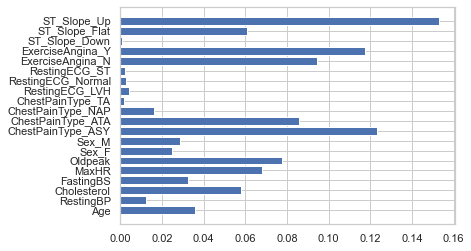

In [87]:
plt.barh(X_train.columns, automl.model.estimator.feature_importances_)

In [85]:
feature_importance = pd.DataFrame(
            {"Feature": X_train.columns,
            "Importance": automl.model.estimator.feature_importances_}
            ).sort_values(by="Importance", ascending=False)

print(feature_importance)

              Feature  Importance
19        ST_Slope_Up    0.153122
8   ChestPainType_ASY    0.123056
16   ExerciseAngina_Y    0.117663
15   ExerciseAngina_N    0.094238
9   ChestPainType_ATA    0.085601
5             Oldpeak    0.077734
4               MaxHR    0.067916
18      ST_Slope_Flat    0.061030
2         Cholesterol    0.057908
0                 Age    0.035825
3           FastingBS    0.032412
7               Sex_M    0.028437
6               Sex_F    0.024745
10  ChestPainType_NAP    0.016043
1           RestingBP    0.012556
12     RestingECG_LVH    0.003990
13  RestingECG_Normal    0.002957
14      RestingECG_ST    0.002188
11   ChestPainType_TA    0.001727
17      ST_Slope_Down    0.000853


c:\Users\vinhe\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



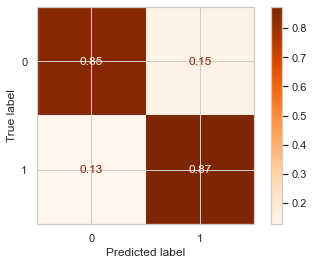

In [77]:
plot_confusion_matrix(automl.model, X_test, y_test, cmap='Oranges', normalize='true')

# Random Forest


In [61]:
# checking the oob score
#print(rf_model.oob_score_)
print('Best hyperparmeter config:', automl.best_config)

Best hyperparmeter config: {'n_estimators': 72, 'max_features': 0.12061632084890749, 'max_leaves': 8, 'criterion': 'entropy'}


In [13]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [4, 8, 15, 30, 40],
    'n_estimators': [30, 50, 70, 100],
    'max_features': [0.05, 0.1, 0.2, 0.4]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, 
                           verbose=2, 
                           scoring="recall"
                           )

In [14]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_features': [0.05, 0.1, 0.2, 0.4],
                         'min_samples_leaf': [4, 8, 15, 30, 40],
                         'n_estimators': [30, 50, 70, 100]},
             scoring='recall', verbose=2)

In [15]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.9409095321296835
{'max_depth': 2, 'max_features': 0.05, 'min_samples_leaf': 30, 'n_estimators': 70}
RandomForestClassifier(max_depth=2, max_features=0.05, min_samples_leaf=30,
                       n_estimators=70, n_jobs=-1, random_state=0)


In [16]:
rf_grid = grid_search.best_estimator_
rf_grid.score(X_train, y_train)


0.8678474114441417

In [17]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred, labels=rf_grid.classes_))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        82
           1       0.85      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



In [18]:
print(confusion_matrix(y_test, y_pred))

[[66 16]
 [13 89]]


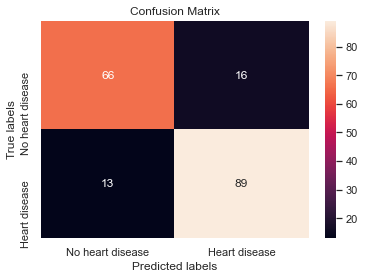

In [43]:
cm = (confusion_matrix(y_test, y_pred))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No heart disease', 'Heart disease']); 
ax.yaxis.set_ticklabels(['No heart disease', 'Heart disease']);

# Compare performance of five optimised models:
1. Random forest FLAML optimised with 60 seconds time budget
2. Random forest FLAML optimised with 600 seconds time budget
3. CatBoost FLAML optimised with 60 seconds time budget
4. CatBoost FLAML optimised with 600 seconds time budget
5. Random forest grid search optimised

In [49]:
# Use the parameters from automl.best_config_per_estimator
rf_flaml_60_seconds = RandomForestClassifier(
    n_estimators = 60,
    max_features =  0.21808890514657167,
    max_leaf_nodes = 30,
    criterion = 'gini'
)

rf_flaml_600_seconds = RandomForestClassifier(
    n_estimators = 72,
    max_features =  0.12061632084890749,
    max_leaf_nodes = 8,
    criterion = 'entropy'
)

cb_flaml_60_seconds = CatBoostClassifier(
    early_stopping_rounds = 10,
    learning_rate = 0.07307260043826526,
    n_estimators = 22,
    logging_level='Silent'
)

cb_flaml_600_seconds = CatBoostClassifier(
    early_stopping_rounds = 16,
    learning_rate = 0.11708776938330147,
    n_estimators = 17,
    logging_level='Silent'
)

In [50]:
optimised_models = {
    'Random forest FLAML optimised - 60 seconds budget': rf_flaml_60_seconds,
    'Random forest FLAML optimised - 600 seconds budget': rf_flaml_600_seconds,
    'CatBoost FLAML optimised - 60 second budget': cb_flaml_60_seconds,
    'CatBoost FLAML optimised - 600 second budget': cb_flaml_600_seconds,
    'Random forest grid search optimised': rf_grid
    }


In [51]:
evaluate_models_multiple_times(
    df_ohe,
    models=optimised_models, 
    number_of_runs=10
    )

For 10 runs of a Random forest FLAML optimised - 60 seconds budget model:
The mean accuracy was 0.866 
The mean precision was 0.857 
The mean recall was 0.912 
The mean F1 score was 0.883 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a Random forest FLAML optimised - 600 seconds budget model:
The mean accuracy was 0.862 
The mean precision was 0.847 
The mean recall was 0.918 
The mean F1 score was 0.88 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a CatBoost FLAML optimised - 60 second budget model:
The mean accuracy was 0.866 
The mean precision was 0.863 
The mean recall was 0.903 
The mean F1 score was 0.882 
This model took 1.0s to run 10 times
---------------------------------------
For 10 runs of a CatBoost FLAML optimised - 600 second budget model:
The mean accuracy was 0.868 
The mean precision was 0.862 
The mean recall was 0.908 
The mean F1 score was 0.884 
This model took 0.8s to 

In [54]:
get_tree_model_feature_importance(X_train, y_train, optimised_models)

Random forest FLAML optimised - 60 seconds budget ------------------------------
   Random forest FLAML optimised - 60 seconds budget Feature  Importance
19                                        ST_Slope_Up           0.179158
18                                      ST_Slope_Flat           0.127403
8                                   ChestPainType_ASY           0.100968
15                                   ExerciseAngina_N           0.087727
5                                             Oldpeak           0.087116
2                                         Cholesterol           0.077575
4                                               MaxHR           0.073261
16                                   ExerciseAngina_Y           0.065860
0                                                 Age           0.038629
1                                           RestingBP           0.033653
6                                               Sex_F           0.022557
7                                          